In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Bidirectional, LSTM
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import keras

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv('../input/historical_stock_prices.csv', index_col='date', parse_dates=['date'])

In [3]:
trainSet = dataset['2015':'2017'].sort_values(by=['ticker','date'])
testSet = dataset['2018':].sort_values(by=['ticker','date'])

In [4]:
trainSet.head()

,ticker,open,close,adj_close,low,high,volume
date,,,,,,,
2015-01-02,A,41.180000,40.560001,39.161114,40.369999,41.310001,1529200
2015-01-05,A,40.320000,39.799999,38.427319,39.700001,40.459999,2041800
2015-01-06,A,39.810001,39.180000,37.828701,39.020000,40.020000,2080600
2015-01-07,A,39.520000,39.700001,38.330769,39.290001,39.810001,3359700
2015-01-08,A,40.240002,40.889999,39.479725,40.180000,40.980000,2116300


In [5]:
symbols = trainSet.ticker.unique()

In [6]:
timesteps = 60
def make_samples(
    data_1,
    s):
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)
    
    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    
                    train_set[s]['x_1'][j].append(sc.transform(x_1))
                    train_set[s]['y'][j].append(sc.transform(y))
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True

In [7]:
# Define train_set
train_set = {}
prediction_intervals = [1,3,5,10]
for s in symbols:
    train_set.update({s:{
        'x_1':{},
        'y':{},
    }})
    for i in prediction_intervals:
        train_set[s]['x_1'][i] = []
        train_set[s]['y'][i] = []
            
    data_1 = trainSet.loc[trainSet['ticker'] == s][['adj_close']].values
        
    make_samples(
        data_1, 
        s)
    
    if s == 'AEGN':
        break

In [8]:
# Callback function
es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, mode='min', restore_best_weights=True)

In [9]:
def make_gru_network():
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    
    regressorGRU.add(GRU(units = 30, return_sequences = False, input_shape=(1,60), activation='tanh'))
    regressorGRU.add(Dropout(0.3))
    
    # The output layer
    regressorGRU.add(Dense(units=1))
    return regressorGRU

In [10]:
# Training model with one feature train_set
model = {}
model_history = {}
for i in prediction_intervals:
    model[i] = make_gru_network()
    model[i].compile(optimizer='rmsprop', loss='mean_squared_error')
    
    n_epoch = 100
    x_train = []
    y_train = []
    
    for s in train_set:
        for j in range (0, len(train_set[s]['x_1'][i])):
            x = [
                train_set[s]['x_1'][i][j],
            ]
            x_train.append(x)
        for j in train_set[s]['y'][i]:
            y_train.append(j)
    X_train, Y_train = np.array(x_train), np.array(y_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    Y_train = Y_train.reshape(Y_train.shape[0])
    
    print(X_train.shape, Y_train.shape)
    print('Fitting prediction interval {}  model'.format(i))
    model_history[i] = model[i].fit(X_train, Y_train, epochs = n_epoch, batch_size = 6000, 
                                    validation_split = 0.3,callbacks=[es])

(59622, 1, 60) (59622,)
Fitting prediction interval 1  model
Train on 41735 samples, validate on 17887 samples
Epoch 1/100
41735/41735 [==============================] - 4s 103us/step - loss: 0.1391 - val_loss: 0.0674
Epoch 2/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0828 - val_loss: 0.0517
Epoch 3/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0666 - val_loss: 0.0425
Epoch 4/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0559 - val_loss: 0.0392
Epoch 5/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0516 - val_loss: 0.0317
Epoch 6/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0451 - val_loss: 0.0330
Epoch 7/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0422 - val_loss: 0.0266
Epoch 8/100
41735/41735 [==============================] - 0s 2us/step - loss: 0.0391 - val_loss: 0.0277
Epoch 9/100
41735/41735 [======================

41598/41598 [==============================] - 0s 2us/step - loss: 0.0401 - val_loss: 0.0357
Epoch 49/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0397 - val_loss: 0.0340
Epoch 50/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0397 - val_loss: 0.0374
Epoch 51/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0397 - val_loss: 0.0339
Epoch 52/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0397 - val_loss: 0.0371
Epoch 53/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0395 - val_loss: 0.0339
Epoch 54/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0398 - val_loss: 0.0374
Epoch 55/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0393 - val_loss: 0.0337
Epoch 56/100
41598/41598 [==============================] - 0s 2us/step - loss: 0.0387 - val_loss: 0.0381
Epoch 57/100
41598/41598 [==============================] -

41461/41461 [==============================] - 0s 2us/step - loss: 0.0508 - val_loss: 0.0503
Epoch 63/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0504 - val_loss: 0.0472
Epoch 64/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0514 - val_loss: 0.0501
Epoch 65/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0504 - val_loss: 0.0471
Epoch 66/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0496 - val_loss: 0.0506
Epoch 67/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0515 - val_loss: 0.0470
Epoch 68/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0492 - val_loss: 0.0481
Epoch 69/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0507 - val_loss: 0.0473
Epoch 70/100
41461/41461 [==============================] - 0s 2us/step - loss: 0.0496 - val_loss: 0.0478
Epoch 71/100
41461/41461 [==============================] -

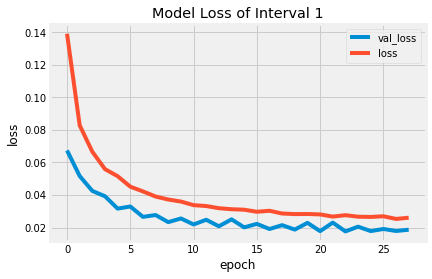

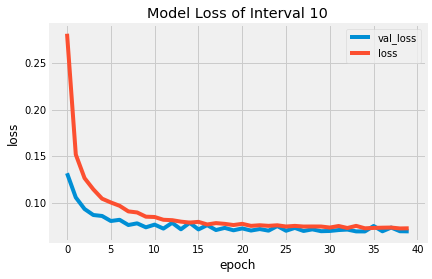

In [12]:
for i in [1,10]:
    plt.plot(model_history[i].history['val_loss'])
    plt.plot(model_history[i].history['loss'])
    plt.title('Model Loss of Interval {}'.format(i))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'loss'], loc='upper right')
    plt.show()

In [14]:
# Calculate Mean squared_error
def return_mse(test,predicted):
    mse = mean_squared_error(test, predicted)
    return mse

In [15]:
# Plotting graph
def plotting_graph(y_test, y_pred, ticker, des):
    plt.plot(y_test, color='green', label='Actual adj_close value')
    plt.plot(y_pred, color='red', label='Predicted adj_close value')
    plt.title('Prediction of {} on {}'.format(ticker, des))
    plt.xlabel('Time steps')
    plt.ylabel('adj_close value')
    plt.legend()
    plt.show()

In [16]:
def make_test_data(s):
    scaler = {s:{}}
    test_set = {s:{}}
    test_set.update({s:{
            'x_1':{},
            'y':{},
        }})
    for i in prediction_intervals:
            test_set[s]['x_1'][i] = []
            test_set[s]['y'][i] = []
            scaler[s][i] = []

    data_1 = testSet.loc[testSet['ticker'] == s][['adj_close']].values
    
    stop_append = {}
    for i in prediction_intervals:
        stop_append.update({i:False}) 
    l = len(data_1)

    for i in range(timesteps, l):
        x_1 = data_1[i-timesteps: i, 0]
        for j in stop_append:
            if not stop_append[j]:
                if i+j-1 < l:
                    y = data_1[i+j-1,0]
                    y = y.reshape(-1,1)
                    x_1 = x_1.reshape(-1,1)
                    
                    sc = MinMaxScaler(feature_range=(0,1))
                    sc.partial_fit(x_1)
                    sc.partial_fit(y)
                    scaler[s][j].append(sc)
                    
                    test_set[s]['x_1'][j].append(sc.transform(x_1))
                    test_set[s]['y'][j].append(y)
                    
                    if y == data_1[l-1,0]:
                        stop_append[j] =True
                    
    return test_set, scaler

In [17]:
def make_prediction(data, s, scaler):
    mse_val = {}
    y_true_val = {}
    y_pred_val = {}
    
    for i in prediction_intervals:
        x_test = []
        for j in range (0, len(data[s]['x_1'][i])):
            x = [
                data[s]['x_1'][i][j],
            ]
            x_test.append(x)

        X_test = np.array(x_test)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
        
        result = model[i].predict(X_test)
        
        y_pred = []
        for j in range(0,len(result)):
            y = result[j]
            y = y.reshape(-1,1)
            k = scaler[s][i][j].inverse_transform(y)
            y_pred.append(k[0][0])
                    
        y_test = data[s]['y'][i]
        y_true = np.array(y_test)
        y_true = y_true.reshape(y_true.shape[0])
    
        y_true_val[i] = y_true
        y_pred_val[i] = y_pred

        mse_val[i] = return_mse(y_true, y_pred) 
    return y_true_val, y_pred_val, mse_val

## Predicting test sample

In [18]:
s = 'AAPL'
data, sc = make_test_data(s)
y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)

for i in mse_val:
    print('Test Set -> MSE of {} inveral {}: {}'.format(s, i, mse_val[i]))

Test Set -> MSE of AAPL inveral 1: 11.298229566448855
Test Set -> MSE of AAPL inveral 3: 27.16997319115512
Test Set -> MSE of AAPL inveral 5: 44.43755648159475
Test Set -> MSE of AAPL inveral 10: 84.17489733863897


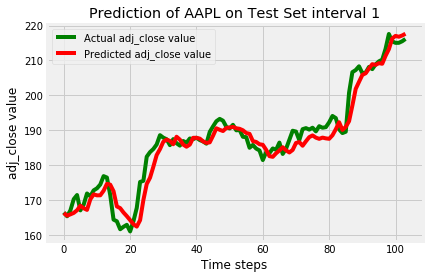

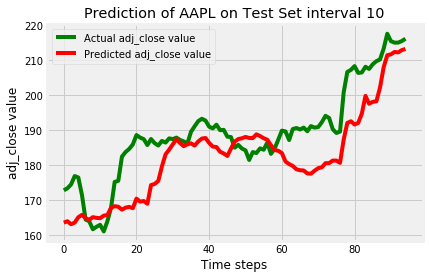

In [19]:
for i in [1,10]:
    plotting_graph(y_true_val[i], y_pred_val[i], s, 'Test Set interval {}'.format(i))

# MSE of 5 symbols

In [20]:
test_symbols = ['A', 'ACER', 'ABC', 'AAPL', 'BABA']

In [21]:
all_mse = {}
for s in test_symbols:
    all_mse[s] = {}
    data, sc = make_test_data(s)
    y_true_val, y_pred_val, mse_val = make_prediction(data, s, sc)
    for i in prediction_intervals:
        all_mse[s][i] = mse_val[i]
        all_mse[s][i] = mse_val[i]

In [22]:
all_mse_1 = []
all_mse_10 = []
for s in all_mse:
    all_mse_1.append(round(all_mse[s][1], 2))
    all_mse_10.append(round(all_mse[s][10], 2))

In [23]:
all_mse_1

[1.64, 1.14, 3.93, 11.3, 18.89]

In [24]:
all_mse_10

[3.81, 5.16, 19.03, 84.17, 94.7]

In [25]:
for i in range(0, len(all_mse_1)):
    print('MSE of Interval 10 = {} Interval 1'.format(round(all_mse_10[i]/all_mse_1[i], 1)))

MSE of Interval 10 = 2.3 Interval 1
MSE of Interval 10 = 4.5 Interval 1
MSE of Interval 10 = 4.8 Interval 1
MSE of Interval 10 = 7.4 Interval 1
MSE of Interval 10 = 5.0 Interval 1
